# Linear regression

## Simple linear regression
In the simplest scenario, the hypothesis, $h(x)$, models a linear affect of an independent variable, $x$, on a dependent variable, $y$.

$$y = h(x) =\theta_{0} + \theta_{1} x$$

The underlying relationship of $\{(x_{0}, y_{1}), (x_{1}, y_{1}), (x_{2}, y_{2}), \ldots, (x_{m}, y_{m})\}$ points can therefore be described as

$$y_{i} = \theta_{0} + \theta_{1} x_{i} + \varepsilon_{i}$$

where $\varepsilon_{i}$ are the residuals, i.e. differences between actual and predicted values of the dependent variable. The "line of best fit" is found by minimizing the square residuals.
$$\min_{\theta_{0}, \theta_{1}}J(\theta_{0}, \theta_{1}) = \sum_{i=0}^{m} \varepsilon_{i}^{2} = \sum_{i=0}^{m} \left(y_{i} - \theta_{0} + \theta_{1} x_{i}\right)^{2}$$

This can be found analytically by finding the stationary point
$$\frac{\partial \varepsilon_{i}^{2}}{\partial \theta_{0}} = 0, \frac{\partial \varepsilon_{i}^{2}}{\partial \theta_{1}} = 0$$

I'm skipping some math because it's a bit more typing that I want to do in LaTeX, but the end result is

$$\theta_{1} = \frac{Cov(x,y)}{Var(x)} = \frac{\sum_{i=1}^{m} (x_{i} - \overline{x})(y_{i} - \overline{y})}{\sum_{i=1}^{m} (x_{i} - \overline{x})^{2}}$$
And
$$\theta_{0} = \overline{y} - \theta_{1} \overline{x}$$

## More general linear regression

Now consider more generally, a model for $n$ input variables. 

$$h(x) = \theta_{0} x_{0} + \theta_{1} x_{1} + \theta_{2} x_{2} \ldots \theta_{n} x_{n} = \sum_{i=0}^{n} \theta_{i} x_{i} = \theta^{T}x$$

The cost function for this can be represented as

$$J(x) = \frac{1}{2m}\sum_{i=0}^{m} \left(h_{\theta}(x_{i}) - y_{i}\right)^{2}$$

There are two ways to find the minimum:
1. Numerically with __gradient descent__
  - More on the algorithm shortly
  - Pros: Works well when $n$ is large, $O(kn^{2})$
  - Cons: Need to tune $\alpha$ (the learning rate), need to iterate (can speed up with *feature scaling* and *mean normalization*)
2. Analytically with the __normal equation__
  - $\theta = \left(X^{T}X\right)^{-1}X^{T}y$
  - Pros: No need to tune $\alpha$, no need to iterate, no need for feature scaling
  - Cons: Slow if $n$ is large, calculating the inverse of $(X^{T}X)$ is $O(n^{3})$
    - If $n > 10k$, better to use gradient descent
    - $X^{T}X$ can be noninvertible if two features are very closely related/redundant (i.e. they are linearly dependent) or too many features


Let's import some libraries and plot the housing prices data for Portland, Oregon from Andrew Ng's course. This data was downloaded from http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex3/ex3.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
%matplotlib inline

import seaborn as sns 
sns.set_context('talk')
sns.set_style('darkgrid')

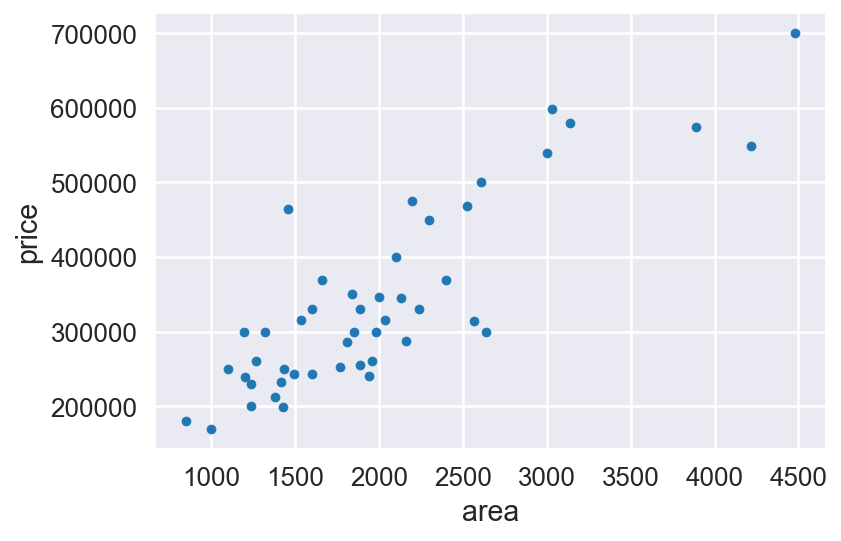

In [2]:
df = pd.read_csv('housing.csv', header=None)
df.columns = ['area', 'num_bdrms', 'price']
df.plot.scatter(x='area', y='price')
plt.show()

Let's fit a line to the above data.

We'll use the following cost function and update rules.

$$J(\theta) = \frac{1}{2m}\sum^{m}_{i=1}\left(h_{\theta}(x^{(i)}) - y^{(i)} \right)^{2}$$

$$\theta_{j} := \theta_{j} - \alpha \frac{1}{m} \sum^{m}_{i=1} \left(h_{\theta}(x^{(i)}) - y^{(i)} \right) x^{(i)}_{j}$$

In [110]:
def hypothesis(thetas, xs):
    return np.dot(thetas, xs)

def cost_function(thetas, xs, ys):
    m = len(xs)
    return (1 / (2 * m)) * sum((np.array(ys) - hypothesis(thetas, xs))**2)

def gradient_descent_update(thetas, xs, ys):
    learning_rate = 0.00000001
    m = len(xs)
    new_thetas = np.empty(len(thetas))
    for j, theta in enumerate(thetas):
        new_thetas[j] = theta - (learning_rate * (1 / m) * sum((hypothesis(thetas, xs) - ys) * xs[j]))
    return new_thetas

In [111]:
areas, ys = df[['area', 'price']].values.T

In [112]:
def minimize(*args, **kwargs):
    ys = kwargs['ys']
    xs = [np.ones(len(ys))]
    for arg in args:
        xs.append(arg)
    xs = np.array(xs)
    costs = []
    input_thetas = kwargs.get('thetas')
    thetas = input_thetas if input_thetas is not None else np.zeros(len(xs))
    for i in range(100):
        costs.append(cost_function(thetas, xs, ys))
        thetas = gradient_descent_update(thetas, xs, ys)
    return {'costs': costs, 'thetas': thetas}

result = minimize(areas, ys=ys)

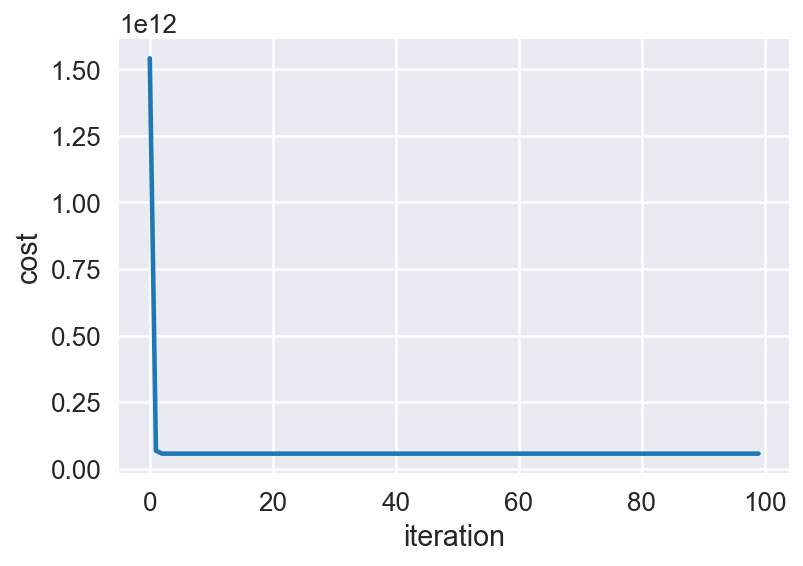

In [113]:
plt.plot(result['costs'])
plt.xlabel('iteration')
plt.ylabel('cost')
plt.show()

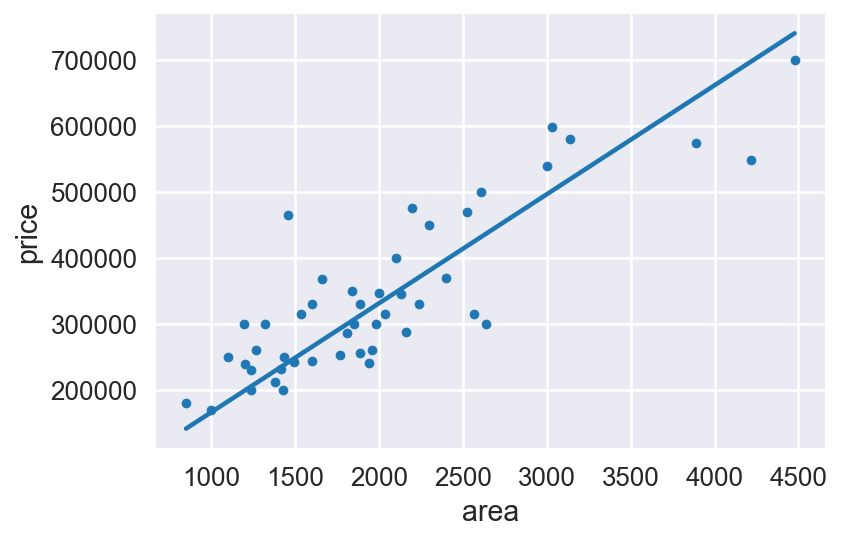

In [114]:
df.plot.scatter(x='area', y='price')
line_xs = range(df.area.min(), df.area.max())
line_ys = [x*result['thetas'][1] + result['thetas'][0] for x in line_xs]
plt.plot(line_xs, line_ys)
plt.show()

In [115]:
result['thetas']

array([  0.29564535, 165.38309078])

Let's compare this to a library to make sure this looks right.

In [116]:
import statsmodels.api as sm
X = sm.add_constant(df.area)
model = sm.OLS(df.price, X)
results = model.fit()
results.params

const    71270.492449
area       134.525288
dtype: float64

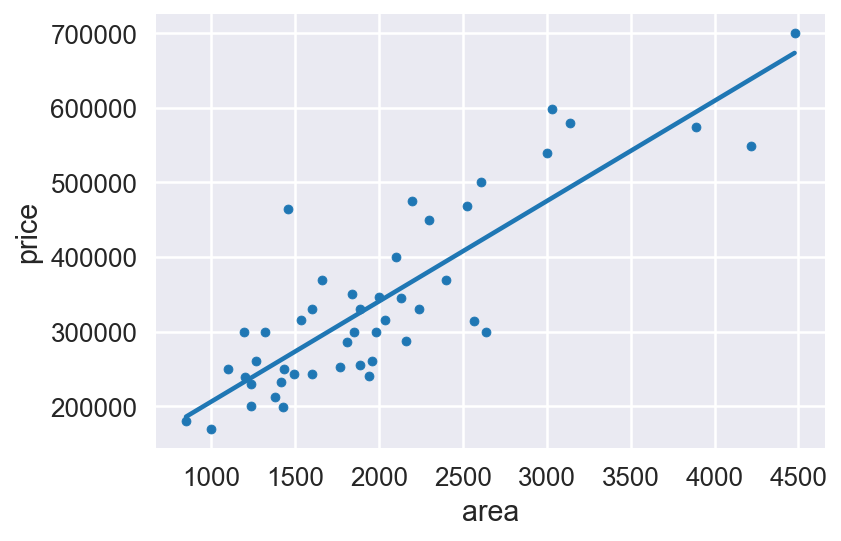

In [117]:
df.plot.scatter(x='area', y='price')
line_xs = range(df.area.min(), df.area.max())
line_ys = [x*results.params.area + results.params.const for x in line_xs]
plt.plot(line_xs, line_ys)
plt.show()

Hmm, they don't quite match. Not sure why ...